## Image segmentation with CamVid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/valid.txt'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/labels'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/codes.txt'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/images')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/images/0016E5_08065.png'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/images/0006R0_f01500.png'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/images/0016E5_06510.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/labels/0006R0_f01770_P.png'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/labels/0006R0_f01290_P.png'),
 PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/camvid/labels/Seq05VD_f02940_P.png')]

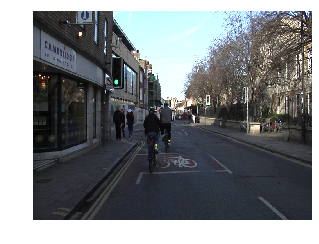

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

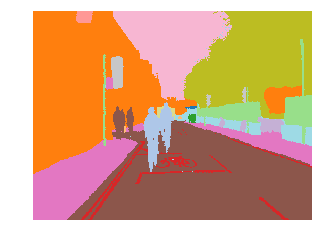

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [ ]:
size = src_size//2
bs=8

In [ ]:
src = (ImageFileList.from_folder(path_img)
       .label_from_func(get_y_fn)
       .split_by_fname_file('../valid.txt'))

In [ ]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

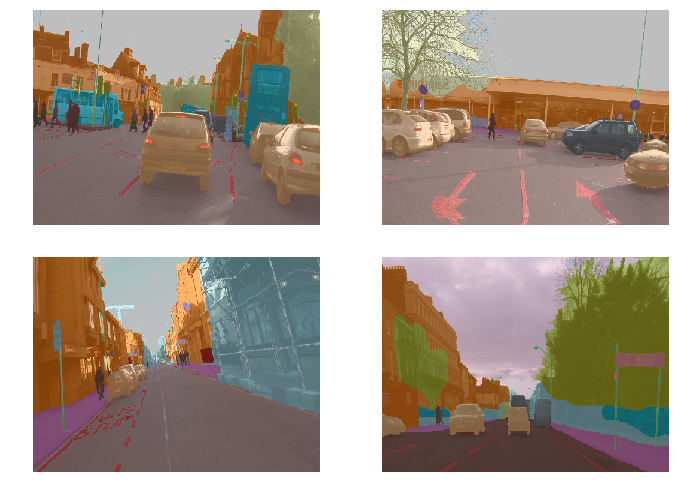

In [ ]:
data.show_batch(2, figsize=(10,7))

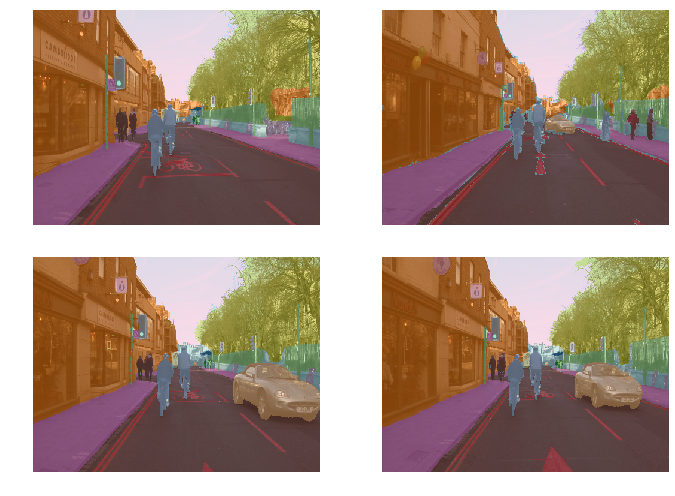

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


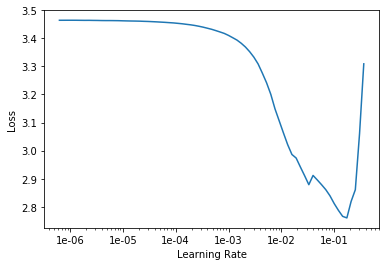

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 02:39
epoch  train_loss  valid_loss  acc_camvid
1      1.624825    0.917785    0.774934    (00:15)
2      0.937823    0.743106    0.810786    (00:15)
3      0.789232    0.996359    0.719544    (00:15)
4      0.700070    0.937673    0.741613    (00:15)
5      0.646315    0.552025    0.849159    (00:15)
6      0.596851    0.475102    0.863902    (00:15)
7      0.551332    0.485613    0.858330    (00:15)
8      0.516999    0.434320    0.871496    (00:16)
9      0.479543    0.395770    0.875477    (00:16)
10     0.458910    0.392731    0.876187    (00:16)



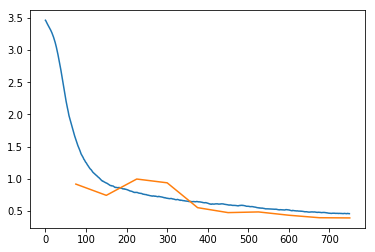

In [ ]:
learn.recorder.plot_losses()

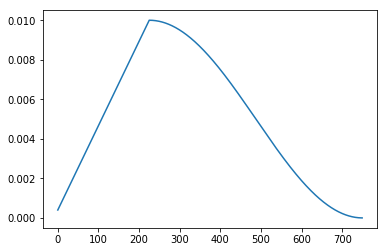

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


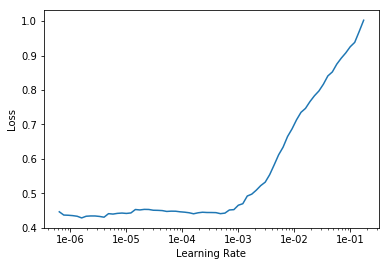

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/10)

In [ ]:
learn.fit_one_cycle(12, lrs)

Total time: 03:32
epoch  train_loss  valid_loss  acc_camvid
1      0.453409    0.401756    0.872208    (00:17)
2      0.460293    0.385767    0.880402    (00:17)
3      0.452243    0.383939    0.880766    (00:17)
4      0.448396    0.381830    0.886434    (00:17)
5      0.448018    0.360350    0.891074    (00:17)
6      0.425992    0.380186    0.883434    (00:17)
7      0.417980    0.400022    0.875282    (00:17)
8      0.404014    0.357821    0.889728    (00:17)
9      0.391446    0.355906    0.890086    (00:17)
10     0.384170    0.357388    0.889609    (00:17)
11     0.379070    0.357881    0.888932    (00:17)
12     0.373773    0.360456    0.887715    (00:17)



In [ ]:
learn.save('stage-2');

## Go big

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


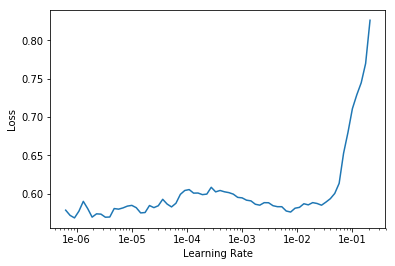

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:11
epoch  train_loss  valid_loss  acc_camvid
1      0.481944    0.374564    0.886332    (00:54)
2      0.445969    0.395118    0.883571    (00:49)
3      0.422841    0.350317    0.892558    (00:49)
4      0.391961    0.351184    0.891048    (00:49)
5      0.383194    0.354457    0.890905    (00:49)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(12, lrs)

Total time: 06:40
epoch  train_loss  valid_loss  acc_camvid
1      0.363479    0.372779    0.885822    (00:33)
2      0.372744    0.370301    0.889697    (00:33)
3      0.377817    0.398087    0.887722    (00:33)
4      0.377816    0.400822    0.877530    (00:33)
5      0.379588    0.381926    0.881407    (00:33)
6      0.370663    0.354900    0.898501    (00:33)
7      0.331817    0.341902    0.894362    (00:33)
8      0.329269    0.327356    0.901787    (00:33)
9      0.315665    0.332719    0.899110    (00:33)
10     0.297474    0.337342    0.899688    (00:33)
11     0.299392    0.329972    0.898885    (00:33)
12     0.298601    0.329742    0.900147    (00:33)

